In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tqdm import tqdm
import plotly.express as px

# Configurar visualizações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas version: {pd.__version__}")
print(f"NetworkX version: {nx.__version__}")


Bibliotecas importadas com sucesso!
Pandas version: 2.3.3
NetworkX version: 3.5


In [13]:
# Carregar dados de autores
print("Carregando dados de autores...")
authors_df = pd.read_csv('database/authorships.csv')
print(f"Total de registros: {len(authors_df):,}")
print(f"Total de trabalhos únicos: {authors_df['work_id'].nunique():,}")
print(f"Total de autores únicos: {authors_df['author_id'].nunique():,}")
print("\nPrimeiras linhas:")
print(authors_df.head())


# Mostrando as colunas do dataframe
print(authors_df.columns)


Carregando dados de autores...
Total de registros: 26,861
Total de trabalhos únicos: 3,574
Total de autores únicos: 10,060

Primeiras linhas:
                            work_id                         author_id  \
0  https://openalex.org/W2566403979  https://openalex.org/A5069790395   
1  https://openalex.org/W2566403979  https://openalex.org/A5104035388   
2  https://openalex.org/W2566403979  https://openalex.org/A5024654137   
3  https://openalex.org/W2566403979  https://openalex.org/A5081300089   
4  https://openalex.org/W2566403979  https://openalex.org/A5026647981   

                 author_name author_position  is_corresponding countries  
0  Luciana Principal Antunes           first              True        BR  
1       Layla Farage Martins          middle             False        BR  
2   Roberta Verciano Pereira          middle             False        BR  
3       Andrew Maltez Thomas          middle             False        BR  
4              Deibs Barbosa          middle

In [4]:
# Verificar quantos trabalhos têm apenas 1 autor
print("Analisando distribuição de autores por trabalho...")
authors_per_work = authors_df.groupby('work_id')['author_id'].nunique()
print(f"Trabalhos com 1 autor: {(authors_per_work == 1).sum():,}")
print(f"Trabalhos com 2+ autores: {(authors_per_work > 1).sum():,}")

# Verificar quantos autores aparecem apenas em trabalhos solo
authors_in_solo_works = set()
authors_in_collaborative_works = set()

for work_id, group in authors_df.groupby('work_id'):
    author_ids = group['author_id'].unique()
    if len(author_ids) == 1:
        authors_in_solo_works.add(author_ids[0])
    else:
        authors_in_collaborative_works.update(author_ids)

print(f"\nAutores que aparecem APENAS em trabalhos solo: {len(authors_in_solo_works - authors_in_collaborative_works):,}")
print(f"Autores que aparecem em trabalhos colaborativos: {len(authors_in_collaborative_works):,}")
print(f"Total de autores únicos: {len(authors_in_solo_works | authors_in_collaborative_works):,}")


Analisando distribuição de autores por trabalho...
Trabalhos com 1 autor: 100
Trabalhos com 2+ autores: 3,474

Autores que aparecem APENAS em trabalhos solo: 0
Autores que aparecem em trabalhos colaborativos: 10,061
Total de autores únicos: 10,061


In [5]:
# Construir grafo de coautoria
# Para cada trabalho, criar arestas entre todos os pares de autores
print("Construindo grafo de coautoria...")

# Criar grafo não direcionado
G = nx.Graph()

# PRIMEIRO: Adicionar TODOS os autores como nós (mesmo os que aparecem apenas em trabalhos solo)
# Isso garante que todos os autores únicos sejam incluídos no grafo
all_author_ids = authors_df['author_id'].unique()
G.add_nodes_from(all_author_ids)
print(f"Adicionados {len(all_author_ids):,} nós (autores) ao grafo")

# SEGUNDO: Agrupar por work_id e criar arestas entre coautores
for work_id, group in tqdm(authors_df.groupby('work_id'), desc="Processando trabalhos"):
    author_ids = group['author_id'].unique()
    # Criar arestas entre todos os pares de autores do mesmo trabalho
    # (apenas se houver 2+ autores no trabalho)
    if len(author_ids) > 1:
        for i, author1 in enumerate(author_ids):
            for author2 in author_ids[i+1:]:
                if G.has_edge(author1, author2):
                    # Incrementar peso da aresta (número de trabalhos em conjunto)
                    G[author1][author2]['weight'] += 1
                else:
                    G.add_edge(author1, author2, weight=1)

print(f"\nGrafo construído:")
print(f"- Número de nós (autores): {G.number_of_nodes():,}")
print(f"- Número de arestas (coautorias): {G.number_of_edges():,}")
print(f"- Densidade: {nx.density(G):.6f}")
print(f"- Autores isolados (sem coautorias): {sum(1 for node in G.nodes() if G.degree(node) == 0):,}")


Construindo grafo de coautoria...
Adicionados 10,061 nós (autores) ao grafo


Processando trabalhos: 100%|██████████| 3574/3574 [00:01<00:00, 3037.67it/s]


Grafo construído:
- Número de nós (autores): 10,061
- Número de arestas (coautorias): 140,854
- Densidade: 0.002783
- Autores isolados (sem coautorias): 0


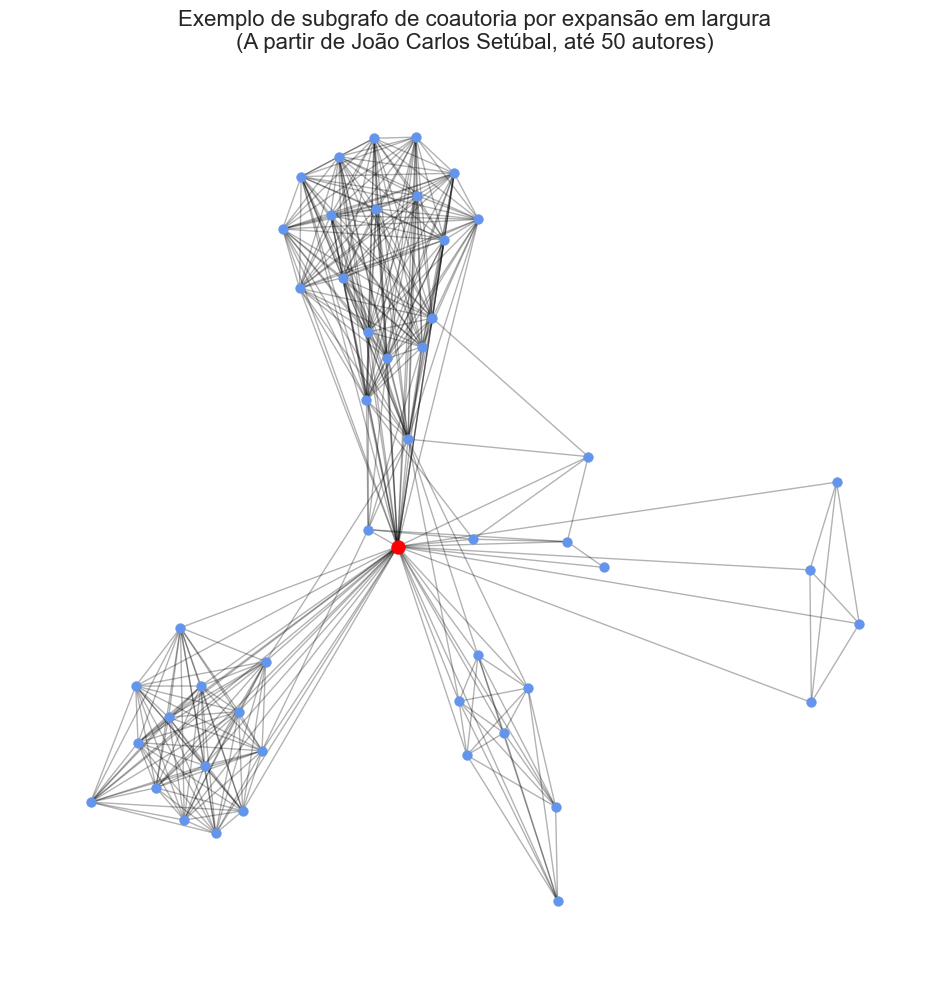

In [6]:
# Visualizar o grafo de coautoria usando expansão em largura (BFS) a partir de um autor central

import matplotlib.pyplot as plt
from collections import deque

plt.figure(figsize=(12, 12))

# Parâmetros
N_EXEMPLO = 50  # Número máximo de nós no subgrafo
# Defina como quiser o autor de partida — por padrão o maior grau
if len(G.nodes) == 0:
    raise ValueError("O grafo está vazio!")

degrees = dict(G.degree())
start_author = max(degrees, key=degrees.get)  # Autor com maior grau

# Expansão em largura (BFS) a partir do start_author
visited = set([start_author])
queue = deque([start_author])
bfs_nodes = [start_author]

while queue and len(bfs_nodes) < N_EXEMPLO:
    current = queue.popleft()
    for neighbor in G.neighbors(current):
        if neighbor not in visited:
            visited.add(neighbor)
            bfs_nodes.append(neighbor)
            queue.append(neighbor)
            if len(bfs_nodes) >= N_EXEMPLO:
                break

subG = G.subgraph(bfs_nodes)

pos = nx.spring_layout(subG, seed=42)

# Desenhar todos os nós em azul primeiro
nx.draw_networkx_nodes(subG, pos, nodelist=[n for n in subG.nodes if n != start_author], node_size=50, node_color='cornflowerblue')

# Mostrar o nó inicial em VERMELHO
nx.draw_networkx_nodes(subG, pos, nodelist=[start_author], node_size=100, node_color='red', label='Autor inicial')

nx.draw_networkx_edges(subG, pos, alpha=0.3)

# Não exibir nenhum label nos nós
plt.title(f'Exemplo de subgrafo de coautoria por expansão em largura\n(A partir de {authors_df.loc[authors_df["author_id"]==start_author, "author_name"].iloc[0]}, até {len(bfs_nodes)} autores)', fontsize=16)
plt.axis('off')
plt.show()


In [7]:
# Classe para predição de links de coautoria
class CoauthorshipLinkPredictor:
    """
    Classe para predição de links de coautoria baseada em distância 2.
    Recomenda autores que são coautores dos coautores do autor alvo.
    """
    
    def __init__(self, graph):
        """
        Inicializa o preditor com um grafo de coautoria.
        
        Args:
            graph: NetworkX Graph com autores como nós e coautorias como arestas
        """
        self.graph = graph
        self.author_to_name = {}
        self._build_author_names()
    
    def _build_author_names(self):
        """Constrói mapeamento de author_id para author_name"""
        unique_authors = authors_df[['author_id', 'author_name']].drop_duplicates()
        self.author_to_name = dict(zip(unique_authors['author_id'], unique_authors['author_name']))
    
    def get_recommendations(self, author_id, top_k=None):
        """
        Obtém recomendações de coautoria para um autor baseado em distância 2.
        
        Args:
            author_id: ID do autor para o qual fazer recomendações
            top_k: Número máximo de recomendações a retornar (None = todas)
        
        Returns:
            Lista de tuplas (author_id, score) ordenada por score decrescente
        """
        if author_id not in self.graph:
            return []
        
        # Obter coautores diretos (distância 1)
        direct_coauthors = set(self.graph.neighbors(author_id))
        
        # Contar quantas vezes cada autor aparece como coautor de coautores
        recommendation_scores = {}
        
        for coauthor in direct_coauthors:
            # Obter coautores do coautor (distância 2 do autor original)
            for potential_coauthor in self.graph.neighbors(coauthor):
                # Ignorar o próprio autor e seus coautores diretos
                if potential_coauthor != author_id and potential_coauthor not in direct_coauthors:
                    # Score baseado no número de caminhos de distância 2
                    if potential_coauthor not in recommendation_scores:
                        recommendation_scores[potential_coauthor] = 0
                    recommendation_scores[potential_coauthor] += 1
        
        # Ordenar por score
        recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
        
        if top_k:
            recommendations = recommendations[:top_k]
        
        return recommendations
    
    def get_recommendations_with_names(self, author_id, top_k=None):
        """
        Obtém recomendações com nomes dos autores.
        
        Args:
            author_id: ID do autor
            top_k: Número máximo de recomendações
        
        Returns:
            Lista de dicionários com author_id, author_name e score
        """
        recommendations = self.get_recommendations(author_id, top_k)
        result = []
        for author_id_rec, score in recommendations:
            result.append({
                'author_id': author_id_rec,
                'author_name': self.author_to_name.get(author_id_rec, 'Unknown'),
                'score': score
            })
        return result
    
    def score_pair(self, author1, author2):
        """
        Retorna um score contínuo para o par de autores baseado em common neighbors.
        Útil para métricas de ranking como AUC e Average Precision.
        
        Args:
            author1: ID do primeiro autor
            author2: ID do segundo autor
        
        Returns:
            Score contínuo (número de common neighbors)
        """
        if author1 not in self.graph or author2 not in self.graph:
            return 0.0
        
        # Contar common neighbors (autores que são coautores de ambos)
        common_neighbors = list(nx.common_neighbors(self.graph, author1, author2))
        return float(len(common_neighbors))

# Testar a classe
predictor = CoauthorshipLinkPredictor(G)
print("Classe CoauthorshipLinkPredictor criada com sucesso!")


Classe CoauthorshipLinkPredictor criada com sucesso!


In [8]:
# Testar recomendações para um autor exemplo
# Pegar um autor que tenha coautores
sample_author = None
for node in G.nodes():
    if G.degree(node) > 0:
        sample_author = node
        break

if sample_author:
    author_name = authors_df[authors_df['author_id'] == sample_author]['author_name'].iloc[0]
    print(f"Testando recomendações para: {author_name} ({sample_author})")
    print(f"Coautores diretos: {G.degree(sample_author)}")
    
    recommendations = predictor.get_recommendations_with_names(sample_author, top_k=10)
    print(f"\nTop 10 recomendações:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['author_name']} (score: {rec['score']})")


Testando recomendações para: Luciana Principal Antunes (https://openalex.org/A5069790395)
Coautores diretos: 33

Top 10 recomendações:
1. Jesus Aparecido Ferro (score: 12)
2. Dirce Maria Carraro (score: 10)
3. Gustavo H. Goldman (score: 10)
4. Leandro Márcio Moreira (score: 10)
5. Suzan Pantaroto de Vasconcellos (score: 10)
6. Nalvo F. Almeida (score: 9)
7. Carlos Henrique Bittencourt Morais (score: 9)
8. María A. Juliano (score: 9)
9. Aline Da Silva (score: 9)
10. Maria Helena S. Goldman (score: 8)


In [9]:
# Classe para avaliação do modelo
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from collections import defaultdict
import random

class CoauthorshipEvaluator:
    """
    Classe para avaliar o modelo de predição de links de coautoria.
    Separa dados em treino/teste (80/20) e calcula métricas.
    """
    
    def __init__(self, graph, test_size=0.2, random_state=42):
        """
        Inicializa o avaliador.
        
        Args:
            graph: NetworkX Graph completo
            test_size: Proporção de arestas para teste (default: 0.2)
            random_state: Seed para reprodutibilidade
        """
        self.full_graph = graph
        self.test_size = test_size
        self.random_state = random_state
        self.train_graph = None
        self.test_edges = None
        self.test_non_edges = None
        self.predictor = None
        
    def split_data(self):
        """
        Separa o grafo em treino (80%) e teste (20%).
        Remove 20% das arestas para teste e mantém 80% para treino.
        CORRIGIDO: Não adiciona todos os nós ao grafo de treino, apenas os envolvidos em arestas de treino.
        Gera negativos apenas entre nós com grau > 0 no treino (casos plausíveis).
        """
        print("Separando dados em treino e teste...")
        
        # Obter todas as arestas
        all_edges = list(self.full_graph.edges())
        random.seed(self.random_state)
        random.shuffle(all_edges)
        
        # Separar 80/20
        split_idx = int(len(all_edges) * (1 - self.test_size))
        train_edges = all_edges[:split_idx]
        test_edges = all_edges[split_idx:]
        
        # Criar grafo de treino APENAS com arestas de treino
        # NÃO adicionar todos os nós - apenas os que aparecem nas arestas de treino
        self.train_graph = nx.Graph()
        self.train_graph.add_edges_from(train_edges)
        # Os nós já são adicionados automaticamente pelo add_edges_from
        
        # Criar preditor com grafo de treino
        self.predictor = CoauthorshipLinkPredictor(self.train_graph)
        
        # Arestas de teste (links positivos)
        self.test_edges = list(test_edges)
        
        # Gerar arestas negativas apenas entre nós com grau > 0 no treino (casos plausíveis)
        print("Gerando arestas negativas plausíveis para teste...")
        train_nodes_with_deg = [n for n in self.train_graph.nodes() if self.train_graph.degree(n) > 0]
        
        if len(train_nodes_with_deg) < 2:
            raise ValueError("Número insuficiente de nós com grau>0 no treino para gerar negativos plausíveis.")
        
        num_negative = len(test_edges)
        negative_edges = set()
        max_attempts = num_negative * 50
        attempts = 0
        
        while len(negative_edges) < num_negative and attempts < max_attempts:
            node1, node2 = random.sample(train_nodes_with_deg, 2)
            # Verificar se não existe aresta no grafo completo E não é a mesma aresta invertida
            if not self.full_graph.has_edge(node1, node2) and (node1, node2) not in negative_edges and (node2, node1) not in negative_edges:
                negative_edges.add((node1, node2))
            attempts += 1
        
        self.test_non_edges = list(negative_edges)
        
        # Filtrar arestas de teste para apenas casos avaliáveis (nós com histórico no treino)
        print("Filtrando arestas de teste para casos avaliáveis...")
        self.test_edges = [e for e in self.test_edges 
                          if e[0] in self.train_graph and self.train_graph.degree(e[0]) > 0]
        self.test_non_edges = [e for e in self.test_non_edges 
                              if e[0] in self.train_graph and self.train_graph.degree(e[0]) > 0]
        
        print(f"Grafo de treino: {self.train_graph.number_of_nodes()} nós, {self.train_graph.number_of_edges()} arestas")
        print(f"  - Nós com grau > 0: {len(train_nodes_with_deg):,}")
        print(f"Arestas de teste (positivas avaliáveis): {len(self.test_edges):,}")
        print(f"Arestas de teste (negativas avaliáveis): {len(self.test_non_edges):,}")
    
    def evaluate(self, top_k=10):
        """
        Avalia o modelo calculando precisão, acurácia e F1-score.
        CORRIGIDO: Agora avalia apenas casos avaliáveis (já filtrados em split_data).
        
        Args:
            top_k: Número de recomendações a considerar para cada autor
        
        Returns:
            Dicionário com métricas
        """
        if self.train_graph is None:
            self.split_data()
        
        print(f"\nAvaliando modelo (top_k={top_k})...")
        
        # Converter para set para busca mais rápida
        test_edges_set = set(self.test_edges)
        test_non_edges_set = set(self.test_non_edges)
        
        # Para cada autor, obter recomendações e verificar se estão no conjunto de teste
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        true_negatives = 0
        
        # Processar arestas positivas de teste (já filtradas para casos avaliáveis)
        for author1, author2 in tqdm(self.test_edges, desc="Avaliando arestas positivas"):
            recommendations = self.predictor.get_recommendations(author1, top_k=top_k)
            recommended_authors = {rec[0] for rec in recommendations}
            
            if author2 in recommended_authors:
                true_positives += 1
            else:
                false_negatives += 1
        
        # Processar arestas negativas de teste (já filtradas para casos avaliáveis)
        for author1, author2 in tqdm(self.test_non_edges, desc="Avaliando arestas negativas"):
            recommendations = self.predictor.get_recommendations(author1, top_k=top_k)
            recommended_authors = {rec[0] for rec in recommendations}
            
            if author2 in recommended_authors:
                false_positives += 1
            else:
                true_negatives += 1
        
        # Calcular métricas
        total = true_positives + false_positives + false_negatives + true_negatives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        accuracy = (true_positives + true_negatives) / total if total > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics = {
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'f1_score': f1,
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'true_negatives': true_negatives,
            'total': total
        }
        
        return metrics
    
    def evaluate_with_auc(self):
        """
        Avalia o modelo usando scores contínuos para calcular ROC AUC e Average Precision.
        Métricas de ranking mais adequadas para link prediction.
        
        Returns:
            Dicionário com roc_auc e average_precision
        """
        if self.train_graph is None:
            self.split_data()
        
        print("\nAvaliando modelo com métricas de ranking (AUC/AP)...")
        
        y_true = []
        y_score = []
        
        # Positivos
        for a, b in tqdm(self.test_edges, desc="Calculando scores para positivos"):
            y_true.append(1)
            y_score.append(self.predictor.score_pair(a, b))
        
        # Negativos
        for a, b in tqdm(self.test_non_edges, desc="Calculando scores para negativos"):
            y_true.append(0)
            y_score.append(self.predictor.score_pair(a, b))
        
        if len(set(y_true)) < 2:
            print("Aviso: Não há classes suficientes para calcular AUC.")
            return None
        
        from sklearn.metrics import roc_auc_score, average_precision_score
        
        try:
            auc = roc_auc_score(y_true, y_score)
            ap = average_precision_score(y_true, y_score)
            return {'roc_auc': auc, 'average_precision': ap}
        except ValueError as e:
            print(f"Erro ao calcular métricas: {e}")
            return None
    
    def precision_at_k_mean(self, top_k=10):
        """
        Calcula Precision@K médio por autor (mais informativo que o agregado global).
        Considera apenas autores com arestas positivas relevantes no conjunto de teste.
        
        Args:
            top_k: Número de recomendações a considerar
        
        Returns:
            Precision@K médio por autor
        """
        if self.train_graph is None:
            self.split_data()
        
        print(f"\nCalculando Precision@{top_k} médio por autor...")
        
        # Agrupar arestas de teste por autor
        test_edges_by_author = defaultdict(set)
        for a, b in self.test_edges:
            test_edges_by_author[a].add(b)
        
        precisions = []
        
        for author in tqdm(test_edges_by_author.keys(), desc="Calculando Precision@K por autor"):
            if self.train_graph.degree(author) == 0:
                continue
            
            recs = self.predictor.get_recommendations(author, top_k=top_k)
            rec_set = {r[0] for r in recs}
            
            # Positivos relevantes para este autor na partição de teste
            relevant = test_edges_by_author[author]
            
            if len(relevant) == 0:
                continue
            
            tp = len(rec_set & relevant)
            precision_k = tp / min(top_k, len(rec_set)) if len(rec_set) > 0 else 0.0
            precisions.append(precision_k)
        
        if not precisions:
            return 0.0
        
        return np.mean(precisions)
    
    def print_metrics(self, metrics):
        """Imprime métricas de forma formatada"""
        print("\n" + "="*50)
        print("MÉTRICAS DE AVALIAÇÃO")
        print("="*50)
        print(f"Precisão (Precision): {metrics['precision']:.4f}")
        print(f"Revocação (Recall):   {metrics['recall']:.4f}")
        print(f"Acurácia (Accuracy):  {metrics['accuracy']:.4f}")
        print(f"F1-Score:             {metrics['f1_score']:.4f}")
        print("\nMatriz de Confusão:")
        print(f"  Verdadeiros Positivos:  {metrics['true_positives']:,}")
        print(f"  Falsos Positivos:       {metrics['false_positives']:,}")
        print(f"  Falsos Negativos:       {metrics['false_negatives']:,}")
        print(f"  Verdadeiros Negativos:  {metrics['true_negatives']:,}")
        print(f"  Total:                  {metrics['total']:,}")
        print("="*50)

print("Classe CoauthorshipEvaluator criada com sucesso!")


Classe CoauthorshipEvaluator criada com sucesso!


In [10]:
# Executar avaliação do modelo (CORRIGIDA)
print("="*60)
print("AVALIAÇÃO")
print("="*60)
evaluator = CoauthorshipEvaluator(G, test_size=0.2, random_state=42)
metrics = evaluator.evaluate(top_k=10)
evaluator.print_metrics(metrics)

# Avaliar com métricas de ranking (AUC e Average Precision)
print("\n" + "="*60)
print("MÉTRICAS DE RANKING (AUC/AP)")
print("="*60)
auc_metrics = evaluator.evaluate_with_auc()
if auc_metrics:
    print(f"ROC AUC:              {auc_metrics['roc_auc']:.4f}")
    print(f"Average Precision:    {auc_metrics['average_precision']:.4f}")

# Precision@K médio por autor
print("\n" + "="*60)
print("PRECISION@K MÉDIO POR AUTOR")
print("="*60)
precision_k_mean = evaluator.precision_at_k_mean(top_k=10)
print(f"Precision@10 médio por autor: {precision_k_mean:.4f}")


AVALIAÇÃO CORRIGIDA - Métricas mais realistas
Separando dados em treino e teste...
Gerando arestas negativas plausíveis para teste...
Filtrando arestas de teste para casos avaliáveis...
Grafo de treino: 10042 nós, 112683 arestas
  - Nós com grau > 0: 10,042
Arestas de teste (positivas avaliáveis): 28,168
Arestas de teste (negativas avaliáveis): 28,171

Avaliando modelo (top_k=10)...


Avaliando arestas negativas: 100%|██████████| 28171/28171 [00:14<00:00, 2005.95it/s]



MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 0.9984
Revocação (Recall):   0.5650
Acurácia (Accuracy):  0.7821
F1-Score:             0.7217

Matriz de Confusão:
  Verdadeiros Positivos:  15,916
  Falsos Positivos:       26
  Falsos Negativos:       12,252
  Verdadeiros Negativos:  28,145
  Total:                  56,339

MÉTRICAS DE RANKING (AUC/AP)

Avaliando modelo com métricas de ranking (AUC/AP)...


Calculando scores para negativos: 100%|██████████| 28171/28171 [00:00<00:00, 243488.65it/s]


ROC AUC:              0.9971
Average Precision:    0.9966

PRECISION@K MÉDIO POR AUTOR

Calculando Precision@10 médio por autor...


Calculando Precision@K por autor: 100%|██████████| 5675/5675 [00:03<00:00, 1611.73it/s]

Precision@10 médio por autor: 0.2872


In [11]:
# Testar com diferentes valores de top_k
print("Avaliando modelo com diferentes valores de top_k...\n")

results = []
for top_k in [5, 10, 20, 50]:
    print(f"\nAvaliando com top_k={top_k}...")
    evaluator_k = CoauthorshipEvaluator(G, test_size=0.2, random_state=42)
    metrics_k = evaluator_k.evaluate(top_k=top_k)
    metrics_k['top_k'] = top_k
    results.append(metrics_k)
    evaluator_k.print_metrics(metrics_k)

# Criar DataFrame com resultados
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("RESUMO DOS RESULTADOS")
print("="*60)
print(results_df[['top_k', 'precision', 'recall', 'accuracy', 'f1_score']].to_string(index=False))


Avaliando modelo com diferentes valores de top_k...


Avaliando com top_k=5...
Separando dados em treino e teste...
Gerando arestas negativas plausíveis para teste...
Filtrando arestas de teste para casos avaliáveis...
Grafo de treino: 10042 nós, 112683 arestas
  - Nós com grau > 0: 10,042
Arestas de teste (positivas avaliáveis): 28,168
Arestas de teste (negativas avaliáveis): 28,171

Avaliando modelo (top_k=5)...


Avaliando arestas negativas: 100%|██████████| 28171/28171 [00:13<00:00, 2124.38it/s]



MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 0.9990
Revocação (Recall):   0.3710
Acurácia (Accuracy):  0.6853
F1-Score:             0.5410

Matriz de Confusão:
  Verdadeiros Positivos:  10,449
  Falsos Positivos:       10
  Falsos Negativos:       17,719
  Verdadeiros Negativos:  28,161
  Total:                  56,339

Avaliando com top_k=10...
Separando dados em treino e teste...
Gerando arestas negativas plausíveis para teste...
Filtrando arestas de teste para casos avaliáveis...
Grafo de treino: 10042 nós, 112683 arestas
  - Nós com grau > 0: 10,042
Arestas de teste (positivas avaliáveis): 28,168
Arestas de teste (negativas avaliáveis): 28,171

Avaliando modelo (top_k=10)...


Avaliando arestas negativas: 100%|██████████| 28171/28171 [00:13<00:00, 2121.65it/s]



MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 0.9984
Revocação (Recall):   0.5650
Acurácia (Accuracy):  0.7821
F1-Score:             0.7217

Matriz de Confusão:
  Verdadeiros Positivos:  15,916
  Falsos Positivos:       26
  Falsos Negativos:       12,252
  Verdadeiros Negativos:  28,145
  Total:                  56,339

Avaliando com top_k=20...
Separando dados em treino e teste...
Gerando arestas negativas plausíveis para teste...
Filtrando arestas de teste para casos avaliáveis...
Grafo de treino: 10042 nós, 112683 arestas
  - Nós com grau > 0: 10,042
Arestas de teste (positivas avaliáveis): 28,168
Arestas de teste (negativas avaliáveis): 28,171

Avaliando modelo (top_k=20)...


Avaliando arestas negativas: 100%|██████████| 28171/28171 [00:13<00:00, 2085.48it/s]



MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 0.9977
Revocação (Recall):   0.7537
Acurácia (Accuracy):  0.8760
F1-Score:             0.8587

Matriz de Confusão:
  Verdadeiros Positivos:  21,231
  Falsos Positivos:       48
  Falsos Negativos:       6,937
  Verdadeiros Negativos:  28,123
  Total:                  56,339

Avaliando com top_k=50...
Separando dados em treino e teste...
Gerando arestas negativas plausíveis para teste...
Filtrando arestas de teste para casos avaliáveis...
Grafo de treino: 10042 nós, 112683 arestas
  - Nós com grau > 0: 10,042
Arestas de teste (positivas avaliáveis): 28,168
Arestas de teste (negativas avaliáveis): 28,171

Avaliando modelo (top_k=50)...


Avaliando arestas negativas: 100%|██████████| 28171/28171 [00:16<00:00, 1661.69it/s]


MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 0.9951
Revocação (Recall):   0.8663
Acurácia (Accuracy):  0.9310
F1-Score:             0.9262

Matriz de Confusão:
  Verdadeiros Positivos:  24,401
  Falsos Positivos:       120
  Falsos Negativos:       3,767
  Verdadeiros Negativos:  28,051
  Total:                  56,339

RESUMO DOS RESULTADOS
 top_k  precision   recall  accuracy  f1_score
     5   0.999044 0.370953  0.685316  0.541021
    10   0.998369 0.565038  0.782069  0.721650
    20   0.997744 0.753728  0.876018  0.858738
    50   0.995106 0.866267  0.931007  0.926227


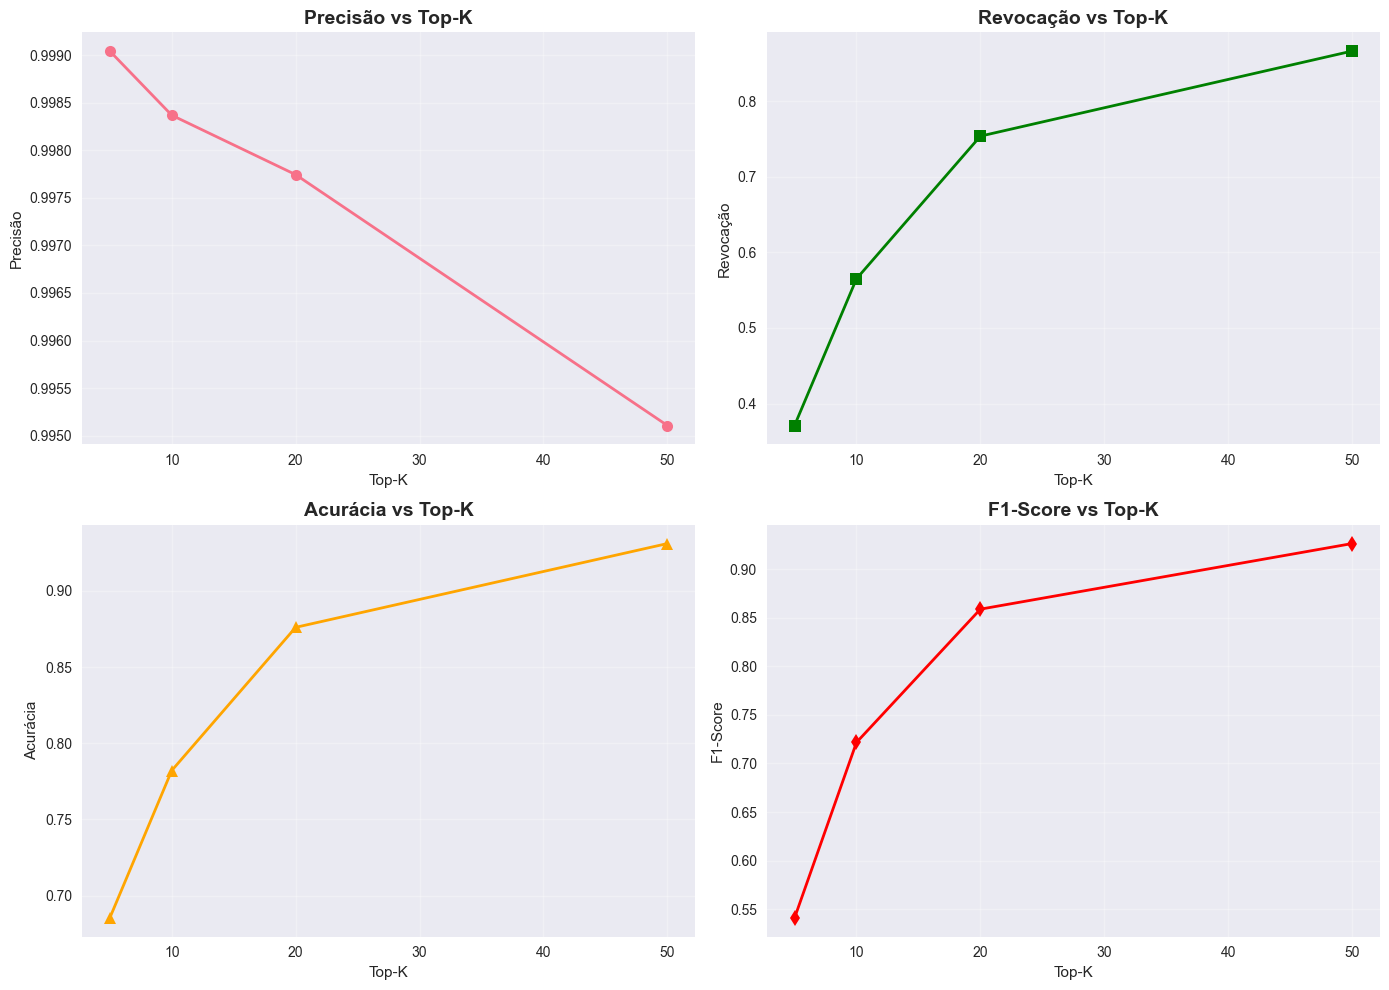

In [12]:
# Visualizar resultados
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(results_df['top_k'], results_df['precision'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Precisão vs Top-K', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Top-K')
axes[0, 0].set_ylabel('Precisão')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(results_df['top_k'], results_df['recall'], marker='s', color='green', linewidth=2, markersize=8)
axes[0, 1].set_title('Revocação vs Top-K', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Top-K')
axes[0, 1].set_ylabel('Revocação')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(results_df['top_k'], results_df['accuracy'], marker='^', color='orange', linewidth=2, markersize=8)
axes[1, 0].set_title('Acurácia vs Top-K', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Top-K')
axes[1, 0].set_ylabel('Acurácia')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(results_df['top_k'], results_df['f1_score'], marker='d', color='red', linewidth=2, markersize=8)
axes[1, 1].set_title('F1-Score vs Top-K', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Top-K')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
